In [1]:
import argparse
import time
import sys
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scvelo as scv
import scanpy
import scipy

from torch import optim
from veloproj import *
from sklearn.decomposition import PCA
from IPython import display
from matplotlib import pyplot as plt

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '8e-7',
                               '--n-epochs', '20000',
                               '--g-rep-dim', '100',
                               '--data-dir', '/data/groups/yhhuang/scNT/neuron_splicing_lite.h5ad',
                               '--model-name', 'scNT_model.cpt',
                               '--exp-name', 'CohAE_scNT',
                               '--device', 'cuda:3',
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")`

In [4]:
cluster_edges = [("0", "15"), ("15", "30"), ("30", "60"), ("60", "120")]
k_cluster = "time"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args):
    n_cells, n_genes = adata.X.shape
    z_dim = args.z_dim
    g_rep_dim = args.g_rep_dim
    h_dim = args.h_dim
    k_dim = args.k_dim
    
    G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())
    
    model = get_veloAE(
                     adata, 
                     z_dim, 
                     n_genes, 
                     n_cells, 
                     h_dim, 
                     k_dim, 
                     G_embeddings=G_embeddings, 
                     g_rep_dim=g_rep_dim,
                     device=device
                    )
    
    optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    
    model.train()
    i, losses = 0, [sys.maxsize]
    while i < args.n_epochs:
        i += 1
        loss = train_step_AE([tensor_u, tensor_s, tensor_x], model, optimizer)                
        losses.append(loss)
        if i % args.log_interval == 0:
            plt.plot(losses[1:])
            display.clear_output(wait=True)
            plt.show()
            print("Train Epoch: {:2d} Loss: {:.6f}"
                  .format(i, losses[-1]))
                
    plt.plot(losses[1:])
    display.clear_output(wait=True)
    plt.show()
    print(losses[-1])
    torch.save(model.state_dict(), args.model_name)

In [6]:
adata = scanpy.read_h5ad(args.data_dir)
scv.utils.show_proportions(adata)
adata.obs['time'] = adata.obs.time.astype('category')
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.83 0.17]
Filtered out 39141 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:14) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 3066 × 2000
    obs: 'cellname', 'time', 'early', 'late', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene_short_name', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


computing velocities
    finished (0:00:00) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_scNT_stochastical.png


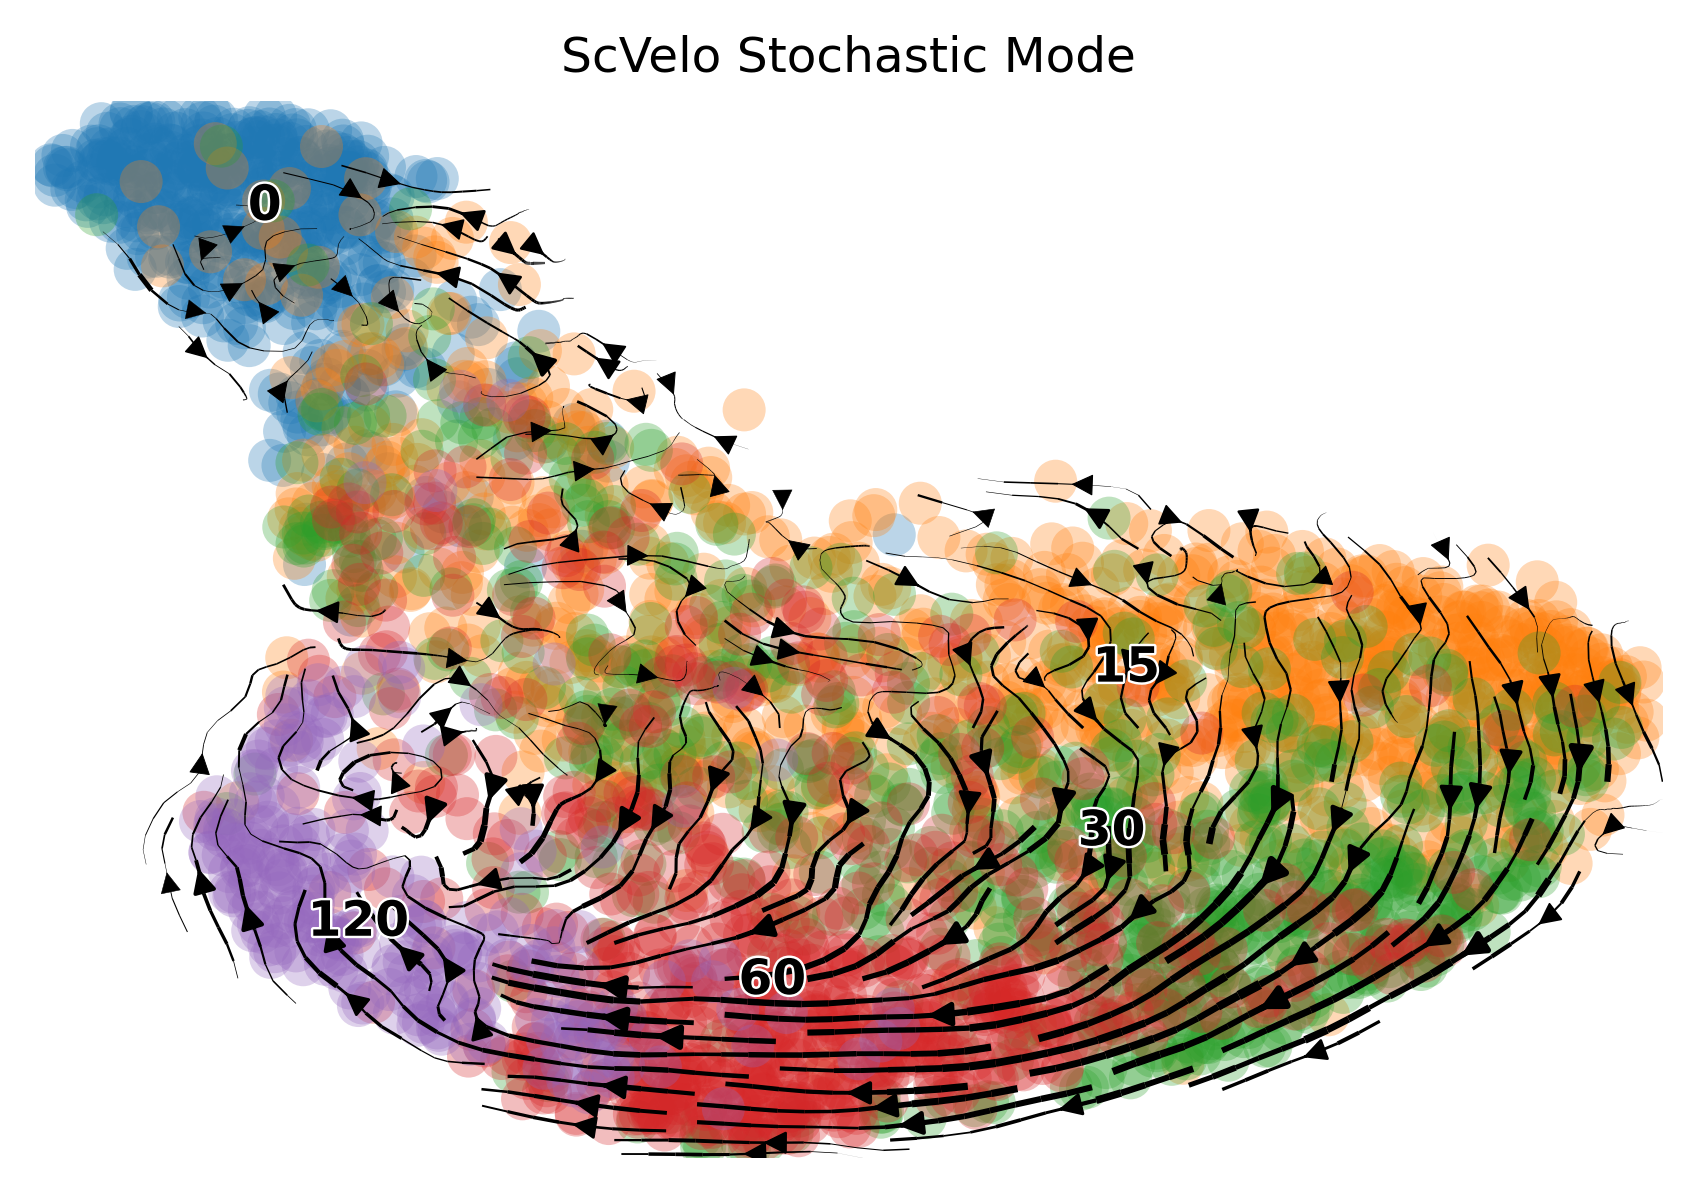

# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.18048683, ('15', '30'): 0.18492232, ('30', '60'): 0.23317656, ('60', '120'): 0.26242754}
Total Mean: 0.2152533233165741
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.8819104, ('15', '30'): 0.84926486, ('30', '60'): 0.88575625, ('60', '120'): 0.9494799}
Total Mean: 0.8916028141975403
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.1881905019999878, ('15', '30'): 0.183201596664333, ('30', '60'): 0.26051693615496574, ('60', '120'): 0.37970625224987553}
Total Mean: 0.25290382176729054
# In-cluster Coherence
{'0': 0.91480386, '120': 0.9610714, '15': 0.8690307, '30': 0.8744445, '60': 0.95124406}
Total Mean: 0.9141188859939575
# In-cluster Confidence
{'0': 0.5655584201816745, '120': 0.5211345913163219, '15': 0.5152941769720372, '30': 0.5523725957590283, '60': 0.630686758869792}
Total Mean: 0.5570093086197707


In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=['time'],dpi=350,
                                title='ScVelo Stochastic Mode', save="scNT_stochastical.png")
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

In [8]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

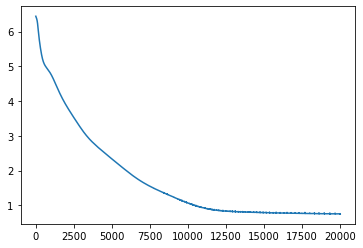

0.7504832744598389


In [9]:
main_AE(args)

In [10]:
n_cells, n_genes = adata.X.shape
z_dim = args.z_dim
g_rep_dim = args.g_rep_dim
h_dim = args.h_dim
k_dim = args.k_dim
    
G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())
model = get_veloAE(
                 adata, 
                 z_dim, 
                 n_genes, 
                 n_cells, 
                 h_dim, 
                 k_dim, 
                 G_embeddings=G_embeddings, 
                 g_rep_dim=g_rep_dim,
                 device=device
                )
model.load_state_dict(torch.load(args.model_name))
model = model.to(device)

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_scNT_pojection.png


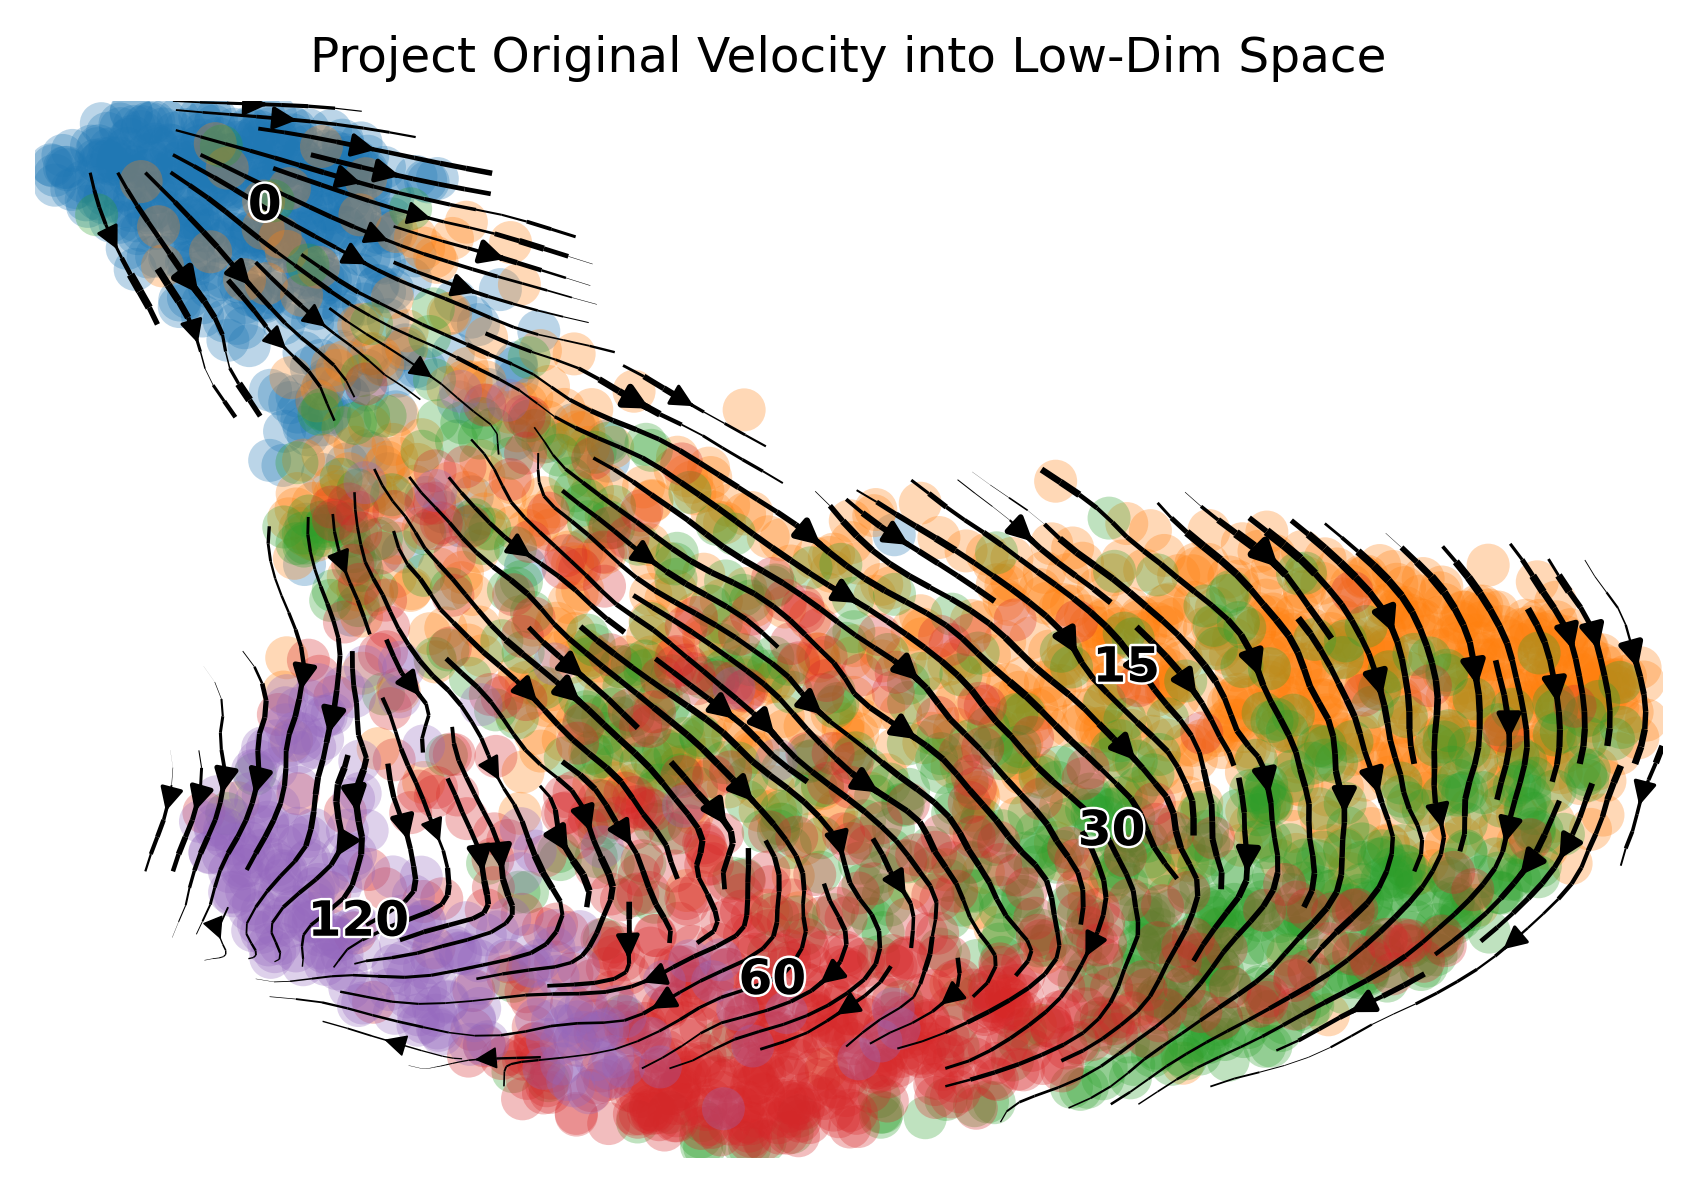

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.428741, ('15', '30'): 0.3979588, ('30', '60'): 0.3231491, ('60', '120'): 0.3039136}
Total Mean: 0.3634406328201294
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.95277965, ('15', '30'): 0.94163996, ('30', '60'): 0.95748305, ('60', '120'): 0.9809529}
Total Mean: 0.9582139253616333
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.7355243132464214, ('15', '30'): 0.4161056869955898, ('30', '60'): 0.2720055084825809, ('60', '120'): 0.1860407980645423}
Total Mean: 0.4024190766972836
# In-cluster Coherence
{'0': 0.96375793, '120': 0.98031217, '15': 0.94525844, '30': 0.9501985, '60': 0.98092276}
Total Mean: 0.9640899896621704
# In-cluster Confidence
{'0': 0.9579495416924991, '120': 0.9778388472667253, '15': 0.9418905312478231, '30': 0.9427372055317331, '60': 0.9770

In [11]:
def exp(adata, exp_metrics):
    x = model.encoder(tensor_x).detach().cpu().numpy()
    s = model.encoder(tensor_s).detach().cpu().numpy()
    u = model.encoder(tensor_u).detach().cpu().numpy()
    v = model.encoder(tensor_s + tensor_v).detach().cpu().numpy() - s
    adata = new_adata(adata, x, s, u, v, False)
    
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=['time'],
                                    title="Project Original Velocity into Low-Dim Space",
                                    dpi=350,
                                    save='scNT_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
exp(adata, exp_metrics)

In [12]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)